In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from astropy.io import fits
from numba import jit
import pandas as pd

data_set_path = r"D:\GRB_data\new_dataset"

# directory to save plots to
save_dir = r"C:\Users\arpan\OneDrive\Documents\GRB\Plots"

# Accessing the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def save_to_dir(fig, filename, directory = save_dir, format='pdf', dpi=400, create_dir=False, **kwargs):
    """
    Save a matplotlib figure to a specified directory with error handling.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    directory : str
        Directory path where the figure should be saved
    filename : str
        Name of the file (without extension)
    format : str, optional
        File format (e.g., 'png', 'pdf', 'svg', 'jpg')
        Default is 'png'
    dpi : int, optional
        Resolution in dots per inch
        Default is 400
    create_dir : bool, optional
        Whether to create the directory if it doesn't exist
        Default is False
    **kwargs : dict
        Additional arguments passed to plt.savefig()
    
    Returns:
    --------
    str
        Path to the saved file if successful, None if failed
    """
    try:
        # Convert directory to Path object
        dir_path = Path(directory)
        
        # Create directory if it doesn't exist and create_dir is True
        if not dir_path.exists():
            if create_dir:
                dir_path.mkdir(parents=True, exist_ok=True)
            else:
                raise FileNotFoundError(f"Directory {directory} does not exist")
        
        # Ensure filename has the correct extension
        if not filename.endswith(f'.{format}'):
            filename = f'{filename}.{format}'
        
        # Create full file path
        file_path = dir_path / filename
        
        # Save the figure
        fig.savefig(
            file_path,
            format=format,
            dpi=dpi,
            bbox_inches='tight',
            **kwargs
        )
        
        print(f"Figure saved successfully to: {file_path}")
        return str(file_path)
        
    except Exception as e:
        print(f"Error saving figure: {str(e)}")
        return None

@jit(nopython=True)
def filter_counts(times, channels, min_ch, max_ch, trigtime):
    counts = []
    for t, ch in zip(times, channels):
        if min_ch <= ch <= max_ch:
            counts.append(t - trigtime)
    return np.array(counts)

def lc_from_folder(folder, bins, chr, label, style_no = 0):

    # Extract event information from folder name
    event_type, event = folder.split("_")

    # Construct file pattern and find matching files
    file_pattern = str(Path(data_set_path) / folder / 'current' / '*_tte_*')
    NaI_detector = glob.glob(file_pattern)

    print(Path(data_set_path) / folder / 'current')

    # check if the file is processed
    if not (Path(data_set_path) / folder / 'current').exists():
        print('folder does not exist')
        return

    if len(NaI_detector) == 0:
        print(f"No matching files found for {folder}")
        return
        
    # changes to accomodate multiple tte files. test this:
    counts_list = []

    for nai in NaI_detector:
        # Read data from FITS file
        with fits.open(nai, memmap=True) as hdul:
            all_count_data = hdul[2].data
            trigtime = float(hdul[2].header['TRIGTIME'])

        # Extract times and channels from all_count_data
        times = all_count_data['TIME'].astype(float)
        channels = all_count_data['PHA'].astype(int)
        
        # Filter counts for different channel ranges
        counts_list.append(filter_counts(times, channels, chr[0], chr[1], trigtime))       

    # putting the counts from different detector into one array
    new_counts_list = []
    
    # Get counts for this energy bin from all detectors and concatenate them
    bin_concat = np.concatenate([counts_list[j] for j in range(0, len(counts_list), 1)])
    new_counts_list.append(bin_concat)

    counts = new_counts_list
            
    # Create histogram
    hist, edges = np.histogram(counts, bins=bins)
    bin_size = bins[1]-bins[0]
    hist = hist / bin_size # converting to rates

    # Plot histogram
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # # Use a modern style
    # plt.style.use(plt.style.available[style_no])
    
    # Plot the histogram as a step plot
    plt.stairs(hist, edges, fill=False, alpha=0.8, color='cornflowerblue', 
            label='Lightcurve')

    # Customize the plot
    plt.xlabel('Time (s)',          fontsize=18)
    plt.ylabel('Counts per second', fontsize=18)
    plt.title(f'{label}', fontsize=18, pad=15)

    # Add grid for better readability
    plt.grid(True, alpha=0.3, linestyle='--')

    # Customize tick labels
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add legend if you have multiple curves
    plt.legend(fontsize=14, loc = 'best')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return fig

                 


index 2052
D:\GRB_data\new_dataset\SGR_bn210911652\current


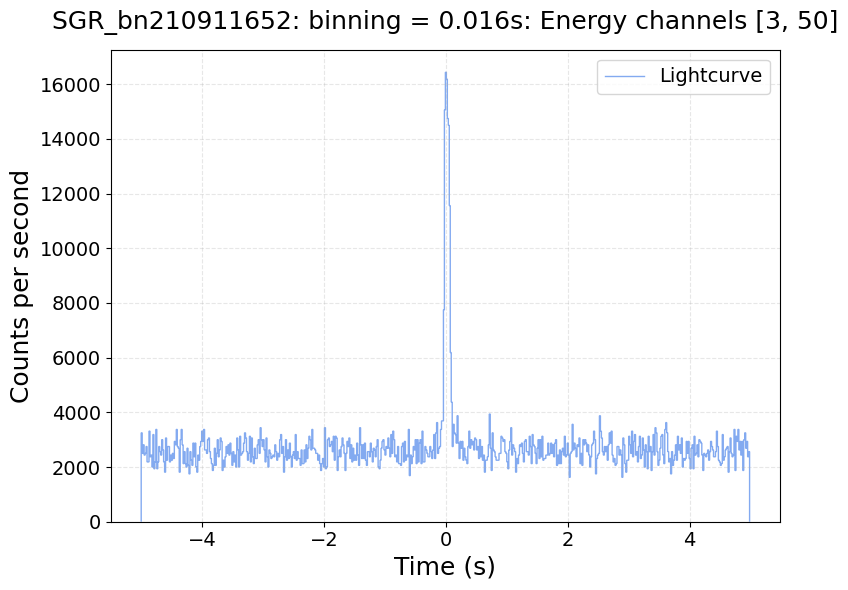

Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\SGR_example.pdf


'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\Plots\\SGR_example.pdf'

In [14]:
# importing the events.csv file
df = pd.read_csv('events.csv')
# print(df.head())
N = len(df)

i = 0
while True:
    i = np.random.randint(0,N)
    # i = 2161
    folder = df.iloc[i]['filename']
    event_type, event = folder.split("_")

    if folder == "SGR_bn210911652":
        break
    # if event_type == 'TGF':
    #     break
print("index",i)


bin_sizes = [0.001, 0.004, 0.016, 0.064, 0.256, 1.024, 4.096]
bin = 2
bins = np.arange(-5,5,bin_sizes[bin])

channels = [3, 50] # 10 to 100 keV
# channels = [51,124] # 100 to 900 keV

fig = lc_from_folder(folder, bins, channels, label=f"{folder}: binning = {bin_sizes[bin]}s: Energy channels {channels}")


plt.show()
save_to_dir(fig, f'{event_type}_example')

In [3]:
print(plt.style.available[12])

seaborn-v0_8-bright
